In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import hashlib
import zlib
import bz2
import bcrypt
import base64
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
img = cv2.imread('adoration-of-the-magi-1500.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

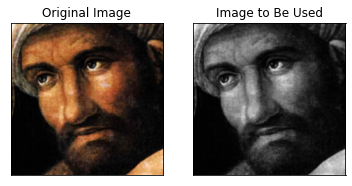

In [3]:
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)), plt.title('Image to Be Used')
plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
block_size = 8
height, width = gray_img.shape
blocks = []
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        block = gray_img[i:i+block_size, j:j+block_size]
        blocks.append(block)
        
dct_blocks = []#intialising dct to each block
for block in blocks:
    dct = cv2.dct(np.float32(block))
    dct_blocks.append(dct)

In [ ]:
from Crypto.Cipher import AES
watermark_data = "1001001 100000 1110111 1100001 1101110 1110100 100000 1110100 1101111 100000 1100111 1101111 100000 1110100 1101111 100000 1001101 1100001 1101100 1110100 1100001"

#zlib + aes
watermark_data_compressed_zlib = zlib.compress(watermark_data.encode())
password = "cse8090"
key = hashlib.sha256(password.encode()).digest()
cipher = AES.new(key, AES.MODE_EAX)
nonce = cipher.nonce
ciphertext_zlib, tag = cipher.encrypt_and_digest(watermark_data_compressed_zlib)

#bz2 + aes
watermark_data_compressed_bz2 = bz2.compress(watermark_data.encode())
cipher = AES.new(key, AES.MODE_EAX)
nonce = cipher.nonce
ciphertext_bz2, tag = cipher.encrypt_and_digest(watermark_data_compressed_bz2)

#binary watermark generation using the two different libraries for compression
binary_watermark_hashlib = [int(bit) for bit in bin(int.from_bytes(hashlib.md5(watermark_data_compressed_zlib).digest(), byteorder='big'))[2:]]

salt = bcrypt.gensalt()
watermark_data_compressed_bz2_encoded = base64.b64encode(watermark_data_compressed_bz2)
binary_watermark_bcrypt = [int(bit) for bit in bin(int.from_bytes(bcrypt.hashpw(watermark_data_compressed_bz2_encoded, salt), byteorder='big'))[2:]]


In [5]:
from Crypto.Cipher import ChaCha20
watermark_data = "1001001 100000 1110111 1100001 1101110 1110100 100000 1110100 1101111 100000 1100111 1101111 100000 1110100 1101111 100000 1001101 1100001 1101100 1110100 1100001"

# Compress the watermark data using zlib
watermark_data_compressed = zlib.compress(watermark_data.encode())



chacha20_key = hashlib.sha256(b'cse8090ismylastproject').digest()
chacha20_nonce = b'01234567'
chacha20_cipher = ChaCha20.new(key=chacha20_key, nonce=chacha20_nonce)
chacha20_encrypted_watermark = chacha20_cipher.encrypt(watermark_data_compressed)

In [6]:
binary_watermark_chacha20 = [int(bit) for bit in bin(int.from_bytes(chacha20_encrypted_watermark, byteorder='big'))[2:]]

In [7]:
binary_watermark = binary_watermark_chacha20

In [ ]:
binary_watermark = binary_watermark_hashlib + binary_watermark_bcrypt

In [ ]:
binary_watermark = binary_watermark_bcrypt

In [ ]:
watermark_data = "1001001 100000 1110111 1100001 1101110 1110100 100000 1110100 1101111 100000 1100111 1101111 100000 1110100 1101111 100000 1001101 1100001 1101100 1110100 1100001"

binary_watermark = ''.join(format(ord(char), '08b') for char in watermark_data)

In [ ]:
block_positions = []
for i in range(len(binary_watermark)):
    if binary_watermark[i] == 1:
        block_positions.append(i)
        
#embed in best positions found using mean square error, think of creating function to allow better optimization
for position in block_positions:
    best_block_index = None
    best_block_mse = None
    for i, block in enumerate(dct_blocks):
        mse = np.mean((block - np.round(block)).flatten() ** 2)
        if best_block_mse is None or mse < best_block_mse:
            best_block_mse = mse
            best_block_index = i
    dct_blocks[best_block_index][0][0] += 1.0 / 256.0
    
watermarked_dct = np.zeros_like(dct_blocks)
for i, dct in enumerate(dct_blocks):
    watermarked_dct[i] = dct
watermarked_blocks = [cv2.idct(np.float32(block)) for block in watermarked_dct]
watermarked_img = np.zeros_like(gray_img)
k = 0
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        watermarked_img[i:i+block_size, j:j+block_size] = watermarked_blocks[k]
        k += 1
    
#inverse is applied again on the image, and saved to new file, this img will be brighter and more noisier without losing quality
marked_dct = np.zeros_like(dct_blocks)
for i, dct in enumerate(dct_blocks):
    marked_dct[i] = dct
marked_blocks = [cv2.idct(np.float32(block)) for block in marked_dct]
marked_img = np.zeros_like(gray_img)
k = 0
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        marked_img[i:i+block_size, j:j+block_size] = marked_blocks[k]
        k += 1


In [ ]:
#PSO parameters
num_particles = 7
max_iterations = 5
inertia_weight = 0.3
cognitive_weight = 0.5
social_weight = 0.5

block_positions = []
for i in range(len(binary_watermark)):
    if binary_watermark[i] == 1:
        block_positions.append(i)
        
# Embed in best positions found using PSO optimization
best_watermarked_blocks = None
best_score = None

positions = np.random.choice(block_positions, size=(num_particles, len(block_positions)), replace=True)
velocities = np.zeros((num_particles, len(block_positions)))


best_positions = np.copy(positions)
best_scores = np.inf * np.ones(num_particles)

#mse for candidateposition
def calculate_score(candidate_position):
    score = 0
    for position in candidate_position:
        best_block_index = None
        best_block_mse = None
        for i, block in enumerate(dct_blocks):
            mse = np.mean((block - np.round(block)).flatten() ** 2)
            if best_block_mse is None or mse < best_block_mse:
                best_block_mse = mse
                best_block_index = i
        dct_blocks[best_block_index][0][0] += 1.0 / 256.0
        score += best_block_mse
    return score



# PSO optimization
for iteration in range(max_iterations):
    for particle in range(num_particles):
        current_position = positions[particle]
        current_velocity = velocities[particle]
        
        # Generate a random candidate position
        candidate_position = np.copy(current_position)
        position_index = np.random.randint(len(block_positions))
        candidate_position[position_index] = np.random.choice(block_positions)
        
        candidate_score = calculate_score(candidate_position)
        
        if candidate_score < best_scores[particle]:
            best_positions[particle] = np.copy(candidate_position)
            best_scores[particle] = candidate_score
        
        if best_score is None or candidate_score < best_score:
            best_watermarked_blocks = np.copy(candidate_position)
            best_score = candidate_score
        
        updated_velocity = (inertia_weight * current_velocity +
                            cognitive_weight * np.random.rand() * (best_positions[particle] - current_position) +
                            social_weight * np.random.rand() * (best_watermarked_blocks - current_position))
        updated_position = current_position + updated_velocity
        
        velocities[particle] = updated_velocity
        positions[particle] = updated_position


watermarked_dct = np.zeros_like(best_watermarked_blocks)
for i, dct in enumerate(best_watermarked_blocks):
    watermarked_dct[i] = dct
watermarked_blocks = [cv2.idct(np.float32(block)) for block in watermarked_dct]
watermarked_img = np.zeros_like(gray_img)
k = 0
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        watermarked_img[i:i+block_size, j:j+block_size] = watermarked_blocks[k]
        k += 1


In [ ]:
cv2.imwrite('watermarked_image1.jpg', watermarked_img)
cv2.imwrite('marked_image1.jpg', marked_img)

In [ ]:
ssim_score, _ = ssim(gray_img, watermarked_img, full=True, multichannel=True)

psnr_score = psnr(gray_img, watermarked_img, data_range=gray_img.max())

# Print the scores
print("SSIM Score:", ssim_score)
print("PSNR Score:", psnr_score)

In [ ]:
ssim_score, _ = ssim(gray_img, marked_img, full=True, multichannel=True)

psnr_score = psnr(gray_img, marked_img, data_range=gray_img.max())

# Print the scores
print("SSIM Score:", ssim_score)
print("PSNR Score:", psnr_score)

In [ ]:

def calculate_ncc(original_image, watermarked_image):
    # Convert the images to numpy arrays
    original_image = np.array(original_image, dtype=np.float64)
    watermarked_image = np.array(watermarked_image, dtype=np.float64)

    # Calculate the mean of the original and watermarked images
    mean_original = np.mean(original_image)
    mean_watermarked = np.mean(watermarked_image)

    # Calculate the cross-correlation term
    cross_correlation = np.sum((original_image - mean_original) * (watermarked_image - mean_watermarked))

    # Calculate the standard deviation of the original and watermarked images
    std_original = np.std(original_image)
    std_watermarked = np.std(watermarked_image)

    # Calculate the NCC
    ncc = cross_correlation / (std_original * std_watermarked)

    return ncc


In [ ]:
# Assuming you have the original image and watermarked image
original_image = gray_img
watermarked_image = watermarked_img


ncc_value = calculate_ncc(gray_img, watermarked_img)

print("NCC value:", ncc_value)

In [ ]:
def calculate_ncc1(gray_img, marked_img):
    gray_img = np.array(gray_img, dtype=np.float64)
    watermarked_img = np.array(marked_img, dtype=np.float64)

    mean_original = np.mean(gray_img)
    mean_watermarked = np.mean(marked_img)

    cross_correlation = np.sum((gray_img - mean_original) * (marked_img - mean_watermarked))

    std_original = np.std(gray_img)
    std_watermarked = np.std(marked_img)

    ncc = cross_correlation / (std_original * std_watermarked)

    return ncc

In [ ]:
def calculate_r_test(gray_img, watermarked_img, binary_watermark):
    gray_img = np.array(gray_img, dtype=np.float64)
    watermarked_img = np.array(watermarked_img, dtype=np.float64)
    binary_watermark = np.array(binary_watermark, dtype=np.float64)

    mean_original = np.mean(gray_img)
    mean_watermarked = np.mean(watermarked_img)

    watermarked_image_zeroed = np.where(binary_watermark == 0, 0, watermarked_img)
    mean_watermarked_zeroed = np.mean(watermarked_image_zeroed)

    # Calculate the numerator and denominator of the R-test formula
    numerator = np.sum((gray_img - mean_original) * (watermarked_image_zeroed - mean_watermarked_zeroed))
    denominator = np.sqrt(np.sum((gray_img - mean_original) ** 2) * np.sum((watermarked_image_zeroed - mean_watermarked_zeroed) ** 2))

    r_test = numerator / denominator

    return r_test

In [ ]:
binary_watermark = np.reshape(binary_watermark, watermarked_img.shape)
r_test_value = calculate_r_test(gray_img, watermarked_img, binary_watermark)


In [ ]:
print("R-test value:", r_test_value)